# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить **модель** для задачи классификации, которая **выберет подходящий тариф**. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением **accuracy**. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до **0.75**. Проверьте *accuracy* на тестовой выборке самостоятельно.

**План работы:**
1. [Чтение и знакомство с исходными данными.](#section_1)
2. [Деление исходных данных на тренировочную и тестовую выборки.](#section_2)
3. [Исследование модели](#section_3)
4. [Проверка модели.](#section_4)
5. [Оценка модели.](#section_5)

<a id='section_1'></a>
## 1. Откройть и изучить файл

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, plot_confusion_matrix

In [2]:
try:
    try:
        df = pd.read_csv('datasets/users_behavior.csv') #домашняя версия
    except:
        df = pd.read_csv('/datasets/users_behavior.csv') #сетевая версия
    display(df.head())
except:
    print('Не удалось прочесть файл. Возможно, был указан не верный путь.')

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


**Описание данных**:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Замена **типов данных** на более подходящие: кол-во звонков и СМС может быть исключительно целым числом. Избавление от условных обозначений в пользу **фактических названий** тарифов.

In [4]:
for col in ['calls', 'messages']:
    df[col] = df[col].astype('int')

df['is_ultra'].where(df['is_ultra'] != 1, 'ultra', inplace=True)
df['is_ultra'].where(df['is_ultra'] != 0, 'smart', inplace=True)
df.rename(columns = {'is_ultra':'tariff'}, inplace=True)

df.head()

,calls,minutes,messages,mb_used,tariff
0,40,311.90,83,19915.42,smart
1,85,516.75,56,22696.96,smart
2,77,467.66,86,21060.45,smart
3,106,745.53,81,8437.39,ultra
4,66,418.74,1,14502.75,smart


<a id='section_2'></a>
## 2. Разбейте данные на выборки

Разделите исходные данные на обучающую, валидационную и тестовую выборки.

In [5]:
features = df.drop('tariff', axis=1) # выделение признаков
target = df['tariff']

train_features, other_features, train_target, other_target = train_test_split(
    features, target, test_size=0.40, random_state=1234) # выделение тренировочной выборки

valid_features, test_features, valid_target, test_target = train_test_split(
    other_features, other_target, test_size=0.5, random_state=1234) # выделение валидационной и тестовой выборок

<a id='section_3'></a>
## 3. Исследуйте модели

Задача классификаци - варианты моделей классификации:
- RandomForestClassifier (Слуйчайный лес)
- LogisticRegression (Логистическая регрессия)
- DecisionTreeClassifier (Дерево решений)

Но я проверю все модели

### 3.1. Случайный лес

Максимальная оценка модели: 0.8429237947122862, при кол-ве деревьев: 100, и их глубине: 10


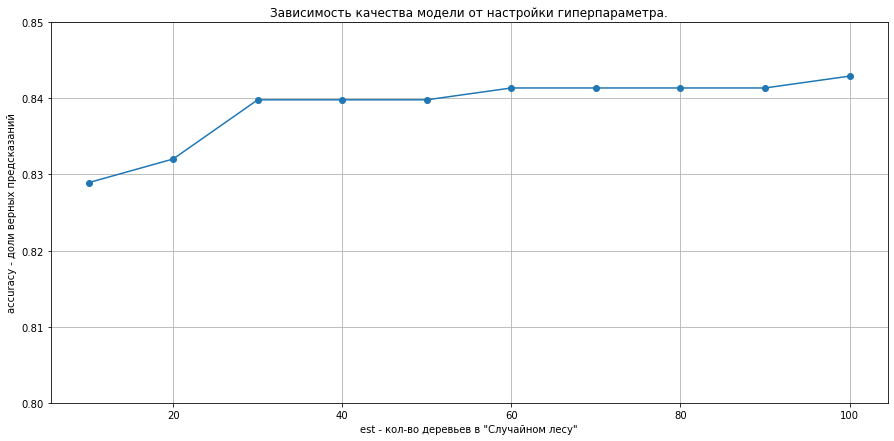

In [6]:
best_est = 0
best_depth = 0
best_accuracy = 0
list_est = []
list_accurasy = []

for est in range(10, 101, 10):
    for depth in range(1, 13):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=1234) # создание модели
        model.fit(train_features, train_target)  # обучение модели
        valid_prediction = model.predict(valid_features) # предсказание на валидационной выборке
        valid_accuracy = accuracy_score(valid_target, valid_prediction) # оценка предсказаний
        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy #фиксация лучших результатов и гиперпараметров
            best_depth = depth
            best_est = est
    list_est.append(est)
    list_accurasy.append(best_accuracy)
    #print(est, best_accuracy) # пошаговый вывод заменён на графическое отображение
    
print(f'Максимальная оценка модели: {best_accuracy}, при кол-ве деревьев: {est}, и их глубине: {best_depth}')

accurasy_data = pd.DataFrame({'est': list_est, 'accuracy': list_accurasy})
accurasy_data.plot(style='o-', x='est', y='accuracy', grid=True, legend=False, figsize=(15,7),
         title='Зависимость качества модели от настройки гиперпараметра.',
         xlabel='est - кол-во деревьев в "Случайном лесу"', ylabel='accuracy - доли верных предсказаний')
plt.ylim(0.80, 0.85);
plt.show()

### 3.2. Логистическая регрессия

In [7]:
best_iter = 0
best_accuracy = 0
for iteration in range(100, 1001, 100):
    model = LogisticRegression(max_iter=iteration, solver='lbfgs', random_state=1234)
    model.fit(train_features, train_target)
    valid_prediction = model.predict(valid_features)
    valid_accuracy = accuracy_score(valid_target, valid_prediction) # оценка предсказаний
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        best_iter = iteration

print(f'Максимальная оценка качества модели: {best_accuracy}, при количестве итераций: {best_iter}')

Максимальная оценка качества модели: 0.7589424572317263, при глубине решающего дерева: 100


### 3.3. Решающее дерево

In [8]:
best_depth = 0
best_accuracy = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(max_depth=depth, random_state=1234)
    model.fit(train_features, train_target)
    valid_prediction = model.predict(valid_features)
    valid_accuracy = accuracy_score(valid_target, valid_prediction)
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        best_depth = depth
        best_model = model

print(f'Максимальная оценка качества модели: {best_accuracy}, при глубине решающего дерева: {best_depth}')

Максимальная оценка качества модели: 0.8320373250388803, при глубине решающего дерева: 7


**Вывод:**
- Наиболее точная модель **Случайный лес**: максимальная глубина: 10 разветвлений, достаточное кол-во деревьев: 60. Их численность можно увеличивать и дальше, но прирост оценки будет наблюдаться в 3ем знаке после запятой. Эту модель можно использовать, если нет требование в высокой скорости работы.
- Если же такая необходимость есть, то можно использовать **Решающее дерево** (макс. длубина = 7). Незначительное отличие по качеству предсказаний, но ощутимая разница в быстродействии.
- **Логистическая регрессия** - самыя низкокачественная в предсказания.

<a id='section_4'></a>
## 4. Проверьте модель на тестовой выборке

Оценка качества на тестовых данных: 0.8118195956454122


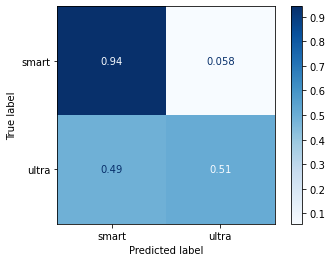

In [12]:
model = RandomForestClassifier(max_depth=10, n_estimators=60, random_state=1234)
model.fit(train_features, train_target)
test_prediction = model.predict(test_features) #предсказание на тестовой выборке

test_accuracy = accuracy_score(test_target, test_prediction)  # Оценка качества на тестовой выборке

plot_confusion_matrix(estimator=model, X=test_features, y_true=test_target, normalize='true', cmap='Blues')

print('Оценка качества на тестовых данных:', test_accuracy)

Доля верных предсказаний, не достаточно велика, чтобы возникла проблема _переобучения_, и в тоже время не достаточно низкая, чтобы вызвать подозрение в _недообучении_. Тариф `smart` модель предсказывает практически идеально, что нельзя сказать про `ultra`. Возможно это связано с разным количеством пользователей этих тарифов.

<a id='section_5'></a>
## 5. Проверьте модели на адекватность (бонус)

Для сравнение я использовал **Dummy**-модель, в качестве базовой модели. Доля верных ответов значительно ниже, что даёт модели **Случайного леса** право на существование. Но одной метрики недостаточно для оценки и я решил дополнить сравнение **матрицей запутанности** (надеюсь этой её правильное название). К сожалению, получился бред. Я ожидал распределние около 30/70. Столько же, сколько пользователей разных тарифов, но 1 и 0 явно не нормально. 

Проверил все переменные и аргументы у функция. Всё верно. Попробовал этот метод оценки с совершенно другим датасетов (другие данные, переменные, модели) -  результат аналогичный. В чём я мог ошибиться?

P.S.: в мыслях был ещё вариант провести **исследовательский анализ данных**, но:
- есть риск субъективно оценить результаты (тем более изначально зная предсказания модели) и 
- хотел избежать ручной работы (автоматизировать процесс), ведь работу модели лучше сравнивать с другой моделью, а не человеком, в данном случае.

Оценка качества Dummy-модель на тестовых данных: 0.6982892690513219


Процентное соотношение пользователей разных тарифов:


,tariff
smart,0.698289
ultra,0.301711


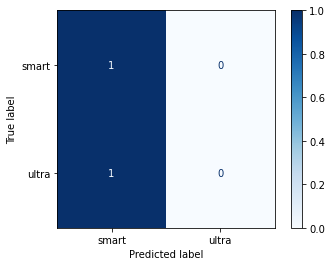

In [32]:
test_model = DummyClassifier() 
test_model.fit(train_features, train_target)

dummy_pred = test_model.predict(test_features)
print('Оценка качества Dummy-модель на тестовых данных:', accuracy_score(test_target, dummy_pred))
print('\n')
print('Процентное соотношение пользователей разных тарифов:')
display(test_target.value_counts(normalize=True).to_frame())

plot_confusion_matrix(estimator=test_model, X=test_features, y_true=test_target, normalize='true', cmap='Blues');

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 4: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75